# Why AI at Nexora?

### At Nexora, many customers browse with a specific vibe or style in mind, not a precise product name. Traditional keyword search fails to capture this intent, leading to missed sales and a frustrating user experience. By implementing an AI-powered semantic search, we bridge this gap. This "vibe matcher" converts our product descriptions into rich vector embeddings, allowing us to understand the meaning behind queries like "energetic urban chic" or "cozy fall outfit." This not only creates a more intuitive and personalized shopping journey but also drives superior product discovery, which directly leads to higher customer engagement and increased conversion rates.




Hugging Face InferenceClient configured.
Total queries: 3, Good matches (>0.7 similarity): 9


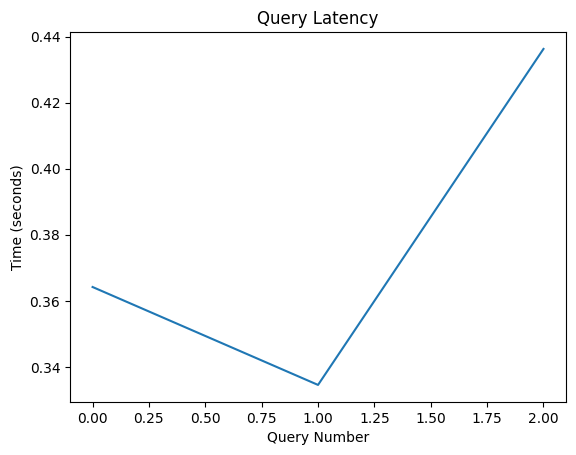


Reflection & Improvements:
- Integrate vector database (e.g., Pinecone) for scalable search.
- Expand dataset with more product details and multi-modal data.
- Implement dynamic thresholding or user feedback to refine matching.
- Handle synonymy and slang in vibe queries for better recall.
- Optimize embedding caching to reduce API calls and latency.



In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import requests
import time
import os
from getpass import getpass
import matplotlib.pyplot as plt
import google.generativeai as genai
from huggingface_hub import InferenceClient
# Step 1: Data Preparation
products = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "vibes": ["boho", "festival"]},
    {"name": "Cozy Sweater", "desc": "Soft, oversized knit for chilly days", "vibes": ["cozy", "casual"]},
    {"name": "Urban Jacket", "desc": "Sleek black bomber, perfect for city nights", "vibes": ["urban", "chic"]},
    {"name": "Elegant Gown", "desc": "Sophisticated silhouette with shimmering details", "vibes": ["elegant", "formal"]},
    {"name": "Sporty Shorts", "desc": "Lightweight, breathable fabric for active days", "vibes": ["sporty", "casual"]},
    # Add more items (5-10 total)
]

df = pd.DataFrame(products)

# Step 2: Generate embeddings for product descriptions using Hugging Face Inference API
# --- Hugging Face Inference Client Setup ---
# 1. Set up API Key securely
if "HF_TOKEN" not in os.environ:
    os.environ["HF_TOKEN"] = getpass("Enter your Hugging Face API Key: ")

hf_api_key = os.getenv("HF_TOKEN")

# ... your client setup code
client = InferenceClient(api_key=hf_api_key)

if not hf_api_key:
    raise ValueError("HF_TOKEN environment variable not set.")

# 2. Configure the client ONCE
# We specify the provider as 'hf-inference'
client = InferenceClient(
    provider="hf-inference", 
    api_key=hf_api_key
)
print("Hugging Face InferenceClient configured.")
# ---

#function definition
def get_embedding(text, model="google/embeddinggemma-300m"):
    """
    Generates an embedding for the given text using the HF Inference API.
    Assumes client has already been configured.
    """
    # The task for embeddings is 'feature_extraction'
    result = client.feature_extraction(
        text,
        model=model
    )
    
    # The API returns the embedding vector directly.
    # If it's a list (for multiple sentences), we convert it.
    # We add np.array() to ensure it's in a good format for cosine_similarity
    return np.array(result)
# --- Example Usage --
# Apply to dataframe
df['embedding'] = df['desc'].apply(get_embedding)


# Step 3: Vector Search and cosine similarity
def vibe_match(query, df, top_k=3, threshold=0.7):
    query_emb = np.array(get_embedding(query)).reshape(1, -1)
    embeddings = np.array(df['embedding'].tolist())
    sims = cosine_similarity(query_emb, embeddings)[0]
    df['similarity'] = sims
    top_matches = df.sort_values(by='similarity', ascending=False).head(top_k)
    
    # fallback if no good match
    if sims.max() < threshold:
        return f"No strong matches found for the vibe '{query}', try a different vibe or check our trending picks."
    
    return top_matches[['name', 'desc', 'similarity']]

# Step 4: Test & Evaluate
queries = ["energetic urban chic", "comfortable casual", "elegant evening wear"]

start_times = []
results = []
good_matches = 0

for q in queries:
    start = time.time()
    res = vibe_match(q, df)
    end = time.time()
    start_times.append(end-start)
    results.append(res)
    if isinstance(res, pd.DataFrame):
        good_matches += sum(res['similarity'] > 0.7)

# Metrics
print(f"Total queries: {len(queries)}, Good matches (>0.7 similarity): {good_matches}")
plt.plot(start_times)
plt.title("Query Latency")
plt.xlabel("Query Number")
plt.ylabel("Time (seconds)")
plt.show()

# Step 5: Reflection (example bullets)
print("""
Reflection & Improvements:
- Integrate vector database (e.g., Pinecone) for scalable search.
- Expand dataset with more product details and multi-modal data.
- Implement dynamic thresholding or user feedback to refine matching.
- Handle synonymy and slang in vibe queries for better recall.
- Optimize embedding caching to reduce API calls and latency.
""")
